In [12]:
import array
import math
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import os

from pykern.pkcollections import PKDict
# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    print("The rslaser library was not found; installing from GitHub...")
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser
from rslaser.optics import wavefront
from rslaser.optics import element
from rslaser.pulse import pulse

import scipy
import scipy.constants as const

# SRW and srwlib (the corresponding Python API) are pre-installed on Sirepo/Jupyter
import srwlib
from srwlib import srwl

In [13]:
# Let's read an image-pair of diagnostic data files to instantiate an SRW wavefront.
# First, we have to determine the file paths...
ccd_name = 'ccd_pump_off.txt'
wfs_name = 'wfs_pump_off.txt'

package_data_dir = rslaser.pkg_resources.resource_filename('rslaser','package_data')
ccd_path_to_file = os.path.join(package_data_dir, ccd_name)
wfs_path_to_file = os.path.join(package_data_dir, wfs_name)

# read the pixel size from the diagnostic metadata file
meta_file_name = 'wfs_meta.dat'
meta_path_to_file = os.path.join(package_data_dir, meta_file_name)
with open(meta_path_to_file) as fh:
    for line in fh:
        if line.startswith("pixel_size_h_microns"):
            pixel_size_h = float(line.split(":")[-1].split(",")[0])  # microns
        if line.startswith("pixel_size_v_microns"):
            pixel_size_v = float(line.split(":")[-1].split(",")[0])  # microns

# central wavelength of the laser pulse
lambda0_micron = 0.8

In [14]:
# parse the wave front sensor (WFS) diagnostic data file
wfs_data = np.genfromtxt(wfs_path_to_file, skip_header=1, skip_footer=0)

# convert from microns to radians
rad_per_micron = math.pi / lambda0_micron
wfs_data *= rad_per_micron

# clean up any NaN's
wfs_data[np.isnan(wfs_data)] = 777
wfs_data[np.where(wfs_data==777)] = np.min(wfs_data)

phi_min=np.min(wfs_data)
phi_max=np.max(wfs_data)

# parse the intensity diagnostic data file
ccd_data = np.genfromtxt(ccd_path_to_file, skip_header=1)

# we assume the WFS and CCD data are from the same diagnostic
# check that the data files have the same number of pixels
assert np.shape(wfs_data) == np.shape(ccd_data), error_message('ERROR -- WFS and CCD data have diferent shapes!!')

n0_min=np.min(ccd_data)
n0_max=np.max(ccd_data)

In [15]:
# create the x,y arrays with physical units based on the diagnostic pixel dimensions
x1_min = 0.
x1_max = (wfs_data.shape[1] + 1.) * pixel_size_h * 1.e-3    # [mm]
x1_delta = (x1_max - x1_min) / wfs_data.shape[1]
x1 = np.arange(x1_min, x1_max, x1_delta)

y1_min = 0.
y1_max = (wfs_data.shape[0] + 1.) * pixel_size_v * 1.e-3    # [mm]
y1_delta = (y1_max - y1_min) / wfs_data.shape[0]
y1 = np.arange(y1_min, y1_max, y1_delta)

In [16]:
e_norm = np.sqrt(ccd_data)
ex_real = np.multiply(e_norm, np.cos(wfs_data)).flatten(order='C')
ex_imag = np.multiply(e_norm, np.sin(wfs_data)).flatten(order='C')

ex_numpy = np.zeros(2*len(ex_real))
for i in range(len(ex_real)):
    ex_numpy[2*i] = ex_real[i]
    ex_numpy[2*i+1] = ex_imag[i]

ex = array.array('f', ex_numpy.tolist())
ey = array.array('f', len(ex)*[0.])


In [17]:
wfr0 = srwlib.SRWLWfr(_arEx=ex, _arEy=ey, _typeE='f', 
                    _eStart=1.55, _eFin=1.55, _ne=1, 
                    _xStart=x1_min, _xFin=x1_max, _nx=np.shape(wfs_data)[0], 
                    _yStart=y1_min, _yFin=y1_max, _ny=np.shape(wfs_data)[1], 
                    _zStart=0., _partBeam=None)

In [18]:
print(' wfr0.mesh.nx = ', wfr0.mesh.nx)
print(' wfr0.mesh.ny = ', wfr0.mesh.ny)
print(' wfr0.mesh.eStart = ', wfr0.mesh.eStart)

 wfr0.mesh.nx =  32
 wfr0.mesh.ny =  40
 wfr0.mesh.eStart =  1.55


Size of initial wavefront data array (coordinate): (32, 40)


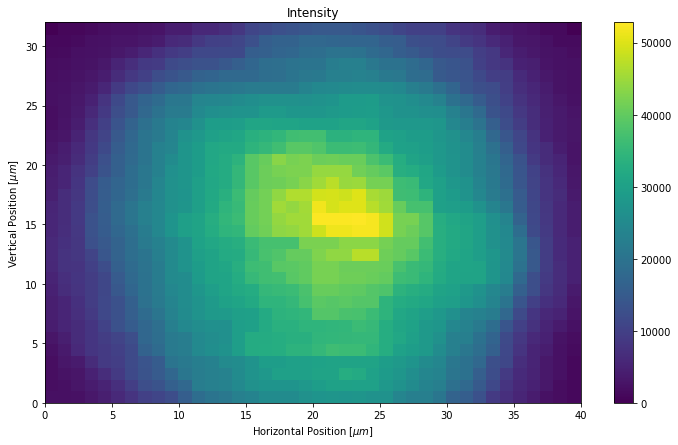

In [19]:
#Plot initial wavefront
##Initial wfr calculation
arIinit = srwlib.array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIinit, wfr0, 6, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
arIinit2D = np.array(arIinit).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
wfrsizei=np.size(arIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(arIinit2D))
xvalsf02=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvalsf02=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

fig = plt.figure(figsize=(12,7))
ax = fig.gca()

# By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
# ax.pcolormesh(x, y, wfs_data, cmap='twilight', vmin=np.min(wfs_data), vmax=np.max(wfs_data), shading='auto')
 
# help(ax.pcolormesh)
# ax.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arIinit2D, cmap=plt.cm.viridis,shading='auto')
plt.pcolormesh(arIinit2D, cmap=plt.cm.viridis,shading='auto')
plt.colorbar()
ax.set_ylabel(r'Vertical Position [$\mu m$]')
ax.set_xlabel(r'Horizontal Position [$\mu m$]')
ax.set_title('Intensity')
plt.show()

In [20]:
# print('arIinit2D = ', arIinit2D)
ccd_new = np.array(arIinit2D)
print('ccd_new = ', ccd_new)

ccd_diff = np.abs(ccd_data - ccd_new)
print('ccd_diff = ', np.max(ccd_diff))


ccd_new =  [[2064.0002  2072.0002  2350.      ... 2271.      1655.      1216.     ]
 [1921.      2266.9998  3076.      ... 3374.      1712.      1171.     ]
 [1920.9999  2673.      3089.      ... 3485.      2311.      1207.     ]
 ...
 [1243.0001  1564.      2171.0002  ... 2548.      2383.      1729.     ]
 [1054.9999  1055.      1479.0001  ... 2388.      1626.0001  1626.     ]
 [   0.       831.       830.99994 ... 1388.      1387.9999     0.     ]]
ccd_diff =  0.00390625


In [21]:
# create a laser pulse with this wavefront

# photon energy corresponding to lambda = 1 micron
_LASER_PULSE_SLICE_DEFAULTS = PKDict(
    sigrW=0.000186,
    propLen=15,
    pulseE=0.001,
    poltype=1,
    sampFact=1,
    mx=0,
    my=0
)
_LASER_PULSE_DEFAULTS = PKDict(
        phE=wfr0.mesh.eStart,
        nslice=1,
        chirp=0,
        w0=.1,
        a0=.01,
        dw0x=0.0,
        dw0y=0.0,
        z_waist=0.,
        dzwx=0.0,
        dzwy=0.0,
        tau_fwhm=0.1 / const.c / math.sqrt(2.),
        z_center=0.,
        x_shift = 0.,
        y_shift=0.,
        d_to_w=0.002,
        slice_params=_LASER_PULSE_SLICE_DEFAULTS,
)

In [22]:
# instantiate the laser pulse (this can take a few seconds)
in_pulse = PKDict(
    **_LASER_PULSE_DEFAULTS
    )
LP = pulse.LaserPulse(in_pulse)

slice=LP.slice
slice[0].wfr = wfr0

In [23]:
# define a simple lattice (negative drift)
L_drift = -0.5 # [m]
drift = element.Drift(L_drift)

lattice = [(drift,'default')]

In [26]:
# propagate the pulse backwards
for iterator in lattice:
    current_elem, prop_type = iterator
    LP = current_elem.propagate(LP, prop_type)

In [27]:
# transmitted pulse - intensity
wfr2=LP.slice[0].wfr

intensity2 = srwlib.array('f', [0]*wfr2.mesh.nx*wfr2.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intensity2, wfr2, 0, 0, 3, wfr2.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
intens_2d_2 = np.array(intensity2).reshape((wfr2.mesh.nx, wfr2.mesh.ny), order='C')
wfrsizei=np.size(intensity2)

print('Size of initial wavefront data array (coordinate):',np.shape(intens_2d_2))
x2=np.linspace(wfr2.mesh.xStart,wfr2.mesh.xFin,wfr2.mesh.nx)
y2=np.linspace(wfr2.mesh.yStart,wfr2.mesh.yFin,wfr2.mesh.ny)

Size of initial wavefront data array (coordinate): (32, 40)


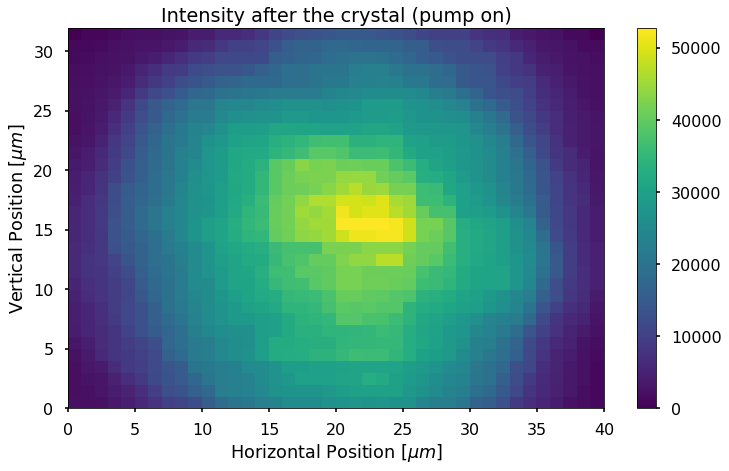

In [29]:
# plot the computed intensity
RENDER_2D_PLOTS = True
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(intens_2d_2, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [$\mu m$]')
        ax.set_xlabel(r'Horizontal Position [$\mu m$]')
        ax.set_title('Intensity after the crystal (pump on)')

In [30]:
# transmitted pulse - phase
wfr3=LP.slice[0].wfr

phase3 = srwlib.array('d', [0]*wfr3.mesh.nx*wfr3.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(phase3, wfr3, 0, 4, 3, wfr3.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase_2d_3 = np.array(phase3).reshape((wfr3.mesh.nx, wfr3.mesh.ny), order='C')
wfrsize=np.size(phase3)

print('Size of initial wavefront data array (coordinate):',np.shape(phase_2d_3))
x3=np.linspace(wfr3.mesh.xStart,wfr3.mesh.xFin,wfr3.mesh.nx)
y3=np.linspace(wfr3.mesh.yStart,wfr3.mesh.yFin,wfr3.mesh.ny)

Size of initial wavefront data array (coordinate): (32, 40)


 
 phase_diff = 1.673 [rad] = 26.626 %
 


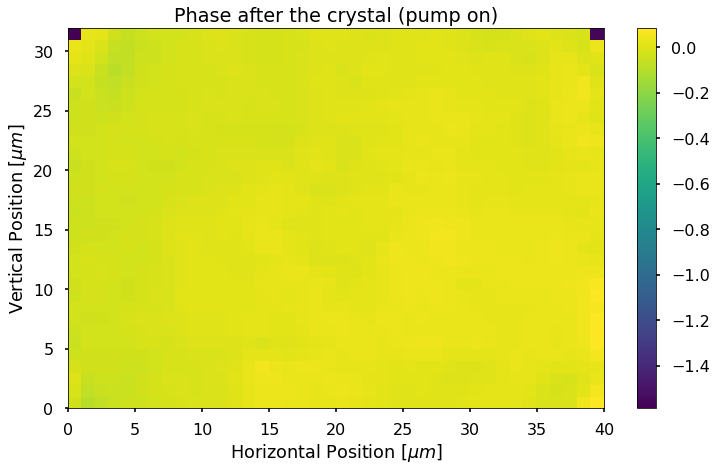

In [32]:
# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(phase_2d_3, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [$\mu m$]')
        ax.set_xlabel(r'Horizontal Position [$\mu m$]')
        ax.set_title('Phase after the crystal (pump on)')
    
    phi_diff = np.max(phase_2d_3) - np.min(phase_2d_3)
    phi_rel_diff = 100. * phi_diff / math.pi / 2.
    print(' ')
    print(' phase_diff = {0:4.3f} [rad]'.format(phi_diff) + ' = {0:4.3f} %'.format(phi_rel_diff))
    print(' ')